# About
Chapter 7 of [Building Machine Learning Systems](https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python). Uses  sklearn's example dataset for regression [boston house-prices dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston). The books code is also [on GitHub](https://github.com/luispedro/BuildingMachineLearningSystemsWithPython)

## Load Data

In [1]:
import sklearn.datasets as data
boston = data.load_boston()

In [2]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [4]:
print(boston.data.shape)

(506, 13)


## Analyse avg. no of rooms vs. price
Plot medium value by avg. number of rooms

Populating the interactive namespace from numpy and matplotlib


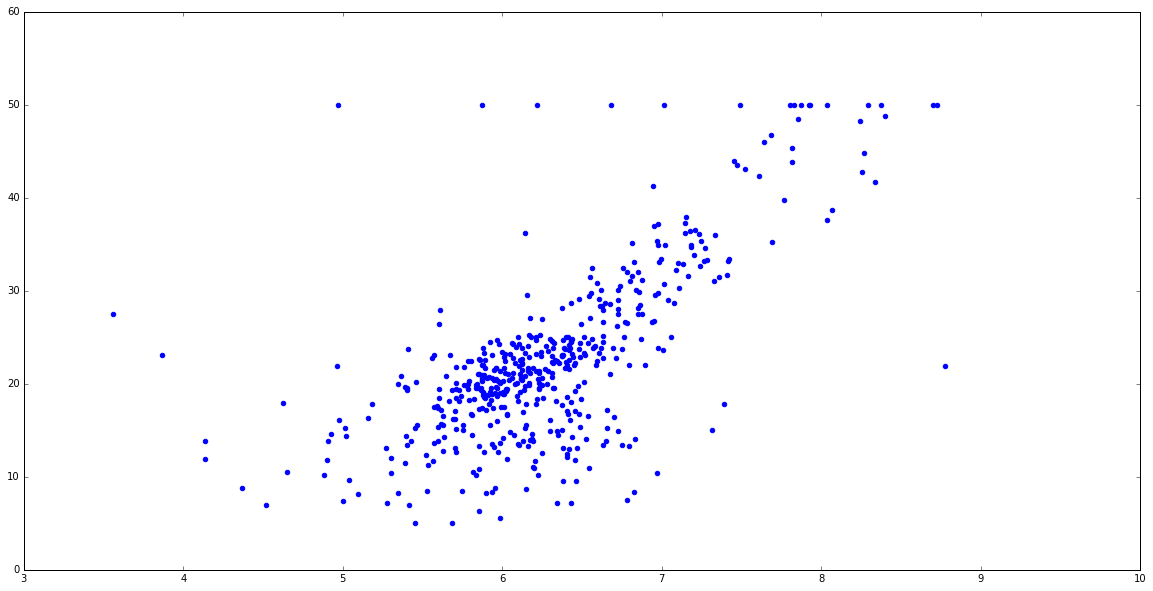

In [5]:
x = boston.data[:,5]
y = boston.target

from matplotlib import pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
plt.scatter(x, y, color='b')

x is a matrix of houses by features. We start with just one feature.

In [6]:
import numpy as np
x = np.array([[v,1] for v in x])

Fit ordinary least square regression (using numpy). Calculate root mean square error.

In [7]:
(slope,bias),total_error,_,_ = np.linalg.lstsq(x,y)
rmse = np.sqrt(total_error / len(x))

In [8]:
    def plot_lstsq(x,y,slope,bias,rmse,labels=("","")):
        """ Plot regression line, confidence band and original data """
        x_min, x_max = x.min(), x.max()
        # Root Mean Squared Error is estimate of standard deviation
        
        fig,ax = plt.subplots()
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.scatter(x,y)
        ax.plot((x_min, x_max), (bias + x_min*slope,bias+x_max*slope),'r-')
        ax.plot((x_min, x_max), (bias + x_min*slope+rmse*2,bias+x_max*slope+rmse*2),'r--')
        ax.plot((x_min, x_max), (bias + x_min*slope-rmse*2,bias+x_max*slope-rmse*2),'r--')
        
        plt.title("""Least Square Estimate: Bias %1.3f, Slope %1.3f, \
RMSE: %1.3f, Confidence Level 0.95\n""" % (bias, slope,rmse))

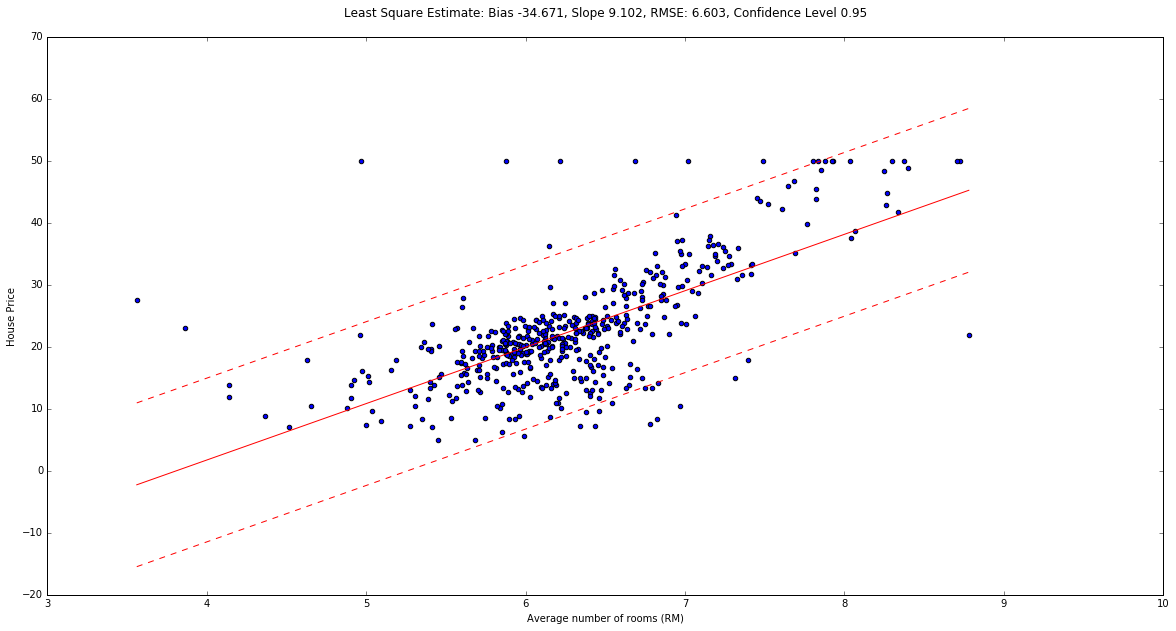

In [9]:
labels=("Average number of rooms (RM)","House Price")
plot_lstsq(x[:,0],y,slope,bias,rmse,labels)

# Multidimesional Regression
An RMSE of 6.6 means we expect real price differ no more than ~13K of the predictions. (Rational: RMSE approximates standard deviation and most data (5% to 95% percentile) are located within twice this value (assumes errors normally distributed)).

How much can we improve by adding more variables? This time we use sklearn's linear regression model because this simplifies exchanging for a more complex model later on. Result: The in-sample RMSE 4.68 of the larger model is much better but this may be due to overfitting the training data. Using cross validation we obtain a more realistic figure of 5.88.

In [10]:
x = boston.data
y = boston.target
# Same model with scikit-learn
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True) # specify
lr.fit(x,y) # train
p = lr.predict(x) # score

In [11]:
# Training RMSE
def rmse(p,y,precision=4):
    e = p - y
    total_error = np.sum(e*e)
    return np.sqrt(total_error / len(p)).round(precision)
rmse(p,y)

4.6795

In [20]:
# k-fold cross validation

def kFold_rmse(model,x,y,n_folds=10):
    from sklearn.cross_validation import KFold
    kf = KFold(x.shape[0],n_folds=n_folds)
    err = 0

    for train,test in kf:
        model.fit(x[train],y[train])
        p = lr.predict(x[test])
        e = p - y[test]
        err += np.sum(e*e)

    rmse_10fold = np.sqrt(err / x.shape[0])
    print('RMSE on %sfold CV: %1.3f' % (n_folds, rmse_10fold))
    return rmse_10fold

kFold_rmse(lr,x,y)    


RMSE on 10fold CV: 5.882


5.8819250724300938

# Preventing Overfitting
Regularization improves test performance. alpha controls degree of regularization. l1_ratio controls mix of LARS and LASSO regularization. See [ElasticNet help](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) for details.

In [12]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(fit_intercept=True, alpha=0.5)

In [13]:
alpha = 1
l1_ratio = 0.5
en = ElasticNet(fit_intercept=True, alpha=alpha, l1_ratio=l1_ratio)
en.fit(x,y)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
kFold_rmse(en,x,y)

RMSE on 10fold CV: 4.689


4.6886619842099968

## P greater N
Risk of overfitting increases by degrees of freedom due to variables with many categories or many variables. New data set [E2006](http://www.cs.cmu.edu/~ark/10K/) contains bag of 150K words of 16K SEC reports and the company's stock volatility thereafter. If data not available execute `download.sh` in `data` folder.

Fitting a full linear regression leads to a training error close to zero. But the out of sample RMSE from cross validation is larger than standard deviation. The model is _worse than predicting the mean_.

Regularization via ElasticNet solves this problem. [`ElasticNetCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) optimizes degree of regularization by selecting model with best validation error in cross validation. 

In [4]:
from sklearn.datasets import load_svmlight_file
data,target = load_svmlight_file('data/E2006.train')
data.shape

(16087, 150360)

In [18]:
from scipy.stats import describe
describe(target)

DescribeResult(nobs=16087, minmax=(-7.8995780734687298, -0.51940952694015396), mean=-3.5140531366944456, variance=0.39980076923806718, skewness=0.06809102496268855, kurtosis=1.3940348917894072)

In [ ]:
sqrt(_.variance)

In [ ]:
lr = LinearRegression()
lr.fit(data,target)
p = lr.predict(data)
rmse(p,target)

In [21]:
kFold_rmse(lr,data,target)

RMSE on 10fold CV: 0.782


0.78213272894627006

In [ ]:
from sklearn.linear_model import ElasticNetCV
netCV = ElasticNetCV(fit_intercept=True)
netCV.fit(data,target)
p = netCV.predict(data)
rmse(p,target)